# <center>  Deep Neural Network (DNN) using plain TensorFlow

## <font color = 'blue'> Get the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from time import time

%store -r
%store

Stored variables and their in-db values:
X_16_val                  -> array([[ 3.00880939,  0.26443017,  1.05370334, ...
X_32_val                  -> array([[-0.13964146,  0.53184264, -0.71694033, ...
X_32test_std              -> defaultdict(<class 'list'>, {0: array([[-0.1396414
X_32train_std             -> array([[-0.80277066, -0.49489511, -0.83240094, ...
X_test                    -> defaultdict(<class 'list'>, {0: array([[[-0.006215
X_test_std                -> defaultdict(<class 'list'>, {0: array([[ 3.0088093
X_train                   -> array([[[-0.01174874, -0.00817356, -0.0042913 , ..
X_train_std               -> array([[-0.80277066, -0.49489511, -0.83240094, ...
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_16_val                  -> array([3, 5, 1, ..., 2, 4, 0])
y_32_test                 -> defaultdict(<class 'list'>, {0: array([2, 2, 3, ..
y_32_train                -> array([5, 0, 2, ..., 4, 6, 6])
y_32_val                  -> array([2, 

In [2]:
print("Training data: ", X_32train_std.shape, "and labels: ", y_32_train.shape)
print(" ")
print("Test data:")
print("Total", len(X_32test_std), X_32test_std[18].shape, "arrays for SNR values:")
print(sorted(X_32test_std.keys()))

Training data:  (80000, 32) and labels:  (80000,)
 
Test data:
Total 20 (4000, 32) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [3]:
# tf.reset_default_graph()

## <font color='blue'> Create validation set required for early stopping

In [4]:
X_val = []
y_val = []

X_test_new = defaultdict(list)
y_test_new = defaultdict(list)

for snr in snrs:
    n_test = X_test_std[snr].shape[0]
    X_val.append(X_test_std[snr][:(n_test*0.5)])
    y_val.append(y_test[snr][:(n_test*0.5)])
    X_test_new[snr] = X_test_std[snr][(n_test*0.5):]
    y_test_new[snr] = y_test[snr][(n_test*0.5):]
    
X_val = np.vstack(np.asarray(X_val))
y_val =np.hstack(np.asarray(y_val))

print("Validation set data", X_val.shape, "and labels", y_val.shape)

X_test_std = X_test_new
y_test = y_test_new

Validation set data (40000, 16) and labels (40000,)


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## <font color = 'blue'> Design and train the DNN

In [5]:
# ----------------- Initialize parameters -----------------------


n_hidden1 = 32
n_hidden2 = 32
n_outputs = 8

X = tf.placeholder(tf.float32, shape=(None, 32))

y = tf.placeholder(tf.int64, shape=(None))

# ------------------- Define layers -----------------------

from tensorflow.contrib.layers import fully_connected

def layer(X, n_neurons, activation):
    layer = fully_connected(X, n_neurons, activation_fn = activation, 
                            weights_initializer = tf.contrib.layers.xavier_initializer())
    return layer

layer1 = layer(X, n_hidden1, activation = tf.nn.elu)

layer2 = layer(layer1, n_hidden2, activation = tf.nn.elu)

logits = layer(layer2, n_outputs, activation = None)

# ----------------- Specify performance measure ----------------------

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
# ------------------ Execution phase ----------------------------------    

n_epochs = 1000
batch_size = 1024
n_train = X_train_std.shape[0]
n_iter = n_train//batch_size

saver = tf.train.Saver()

min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

acc_test = defaultdict(list)

start = time()
path = "./DNN32_elu_xavier.ckpt"

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_iter):
            rand_indices = np.random.choice(n_train,batch_size) #select random samples to form mini batches   
            X_batch, y_batch = X_32train_std[rand_indices], y_32_train[rand_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        valid_loss, acc_val = sess.run([loss, accuracy], feed_dict={X: X_32_val, y: y_32_val})
        
        # Early stopping 
        
        if valid_loss < min_loss:
            save_path = saver.save(sess, path)
            min_loss = valid_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement > max_epochs_without_improvement:
                print("** EARLY STOPPING ** ")
                break
        print("{}\tValidation loss: {:.6f}\tMinimum loss: {:.6f}\tAccuracy on validation set: {:.2f}".format(
            epoch, valid_loss, min_loss, acc_val))

print(" ")
with tf.Session() as sess:
    saver.restore(sess, path)
    for snr in snrs:
        acc_test[snr] = accuracy.eval(feed_dict={X: X_32test_std[snr], y: y_32_test[snr]})

print("Training and testing took %f minutes"%(float(time() - start)/60))

0	Validation loss: 1.700023	Minimum loss: 1.700023	Accuracy on validation set: 0.33
1	Validation loss: 1.601074	Minimum loss: 1.601074	Accuracy on validation set: 0.37
2	Validation loss: 1.536759	Minimum loss: 1.536759	Accuracy on validation set: 0.39
3	Validation loss: 1.491453	Minimum loss: 1.491453	Accuracy on validation set: 0.40
4	Validation loss: 1.455622	Minimum loss: 1.455622	Accuracy on validation set: 0.41
5	Validation loss: 1.426452	Minimum loss: 1.426452	Accuracy on validation set: 0.42
6	Validation loss: 1.403373	Minimum loss: 1.403373	Accuracy on validation set: 0.43
7	Validation loss: 1.383798	Minimum loss: 1.383798	Accuracy on validation set: 0.44
8	Validation loss: 1.369153	Minimum loss: 1.369153	Accuracy on validation set: 0.44
9	Validation loss: 1.355105	Minimum loss: 1.355105	Accuracy on validation set: 0.45
10	Validation loss: 1.345285	Minimum loss: 1.345285	Accuracy on validation set: 0.45
11	Validation loss: 1.335388	Minimum loss: 1.335388	Accuracy on validation 

## <font color = 'blue'> Test the DNN

In [6]:
for snr in snrs:
    print("DNN's test accuracy on %d dB SNR samples = "%(snr), acc_test[snr])   

DNN's test accuracy on -20 dB SNR samples =  0.12625
DNN's test accuracy on -18 dB SNR samples =  0.125
DNN's test accuracy on -16 dB SNR samples =  0.133
DNN's test accuracy on -14 dB SNR samples =  0.13375
DNN's test accuracy on -12 dB SNR samples =  0.15275
DNN's test accuracy on -10 dB SNR samples =  0.1975
DNN's test accuracy on -8 dB SNR samples =  0.303
DNN's test accuracy on -6 dB SNR samples =  0.35725
DNN's test accuracy on -4 dB SNR samples =  0.404
DNN's test accuracy on -2 dB SNR samples =  0.4825
DNN's test accuracy on 0 dB SNR samples =  0.5875
DNN's test accuracy on 2 dB SNR samples =  0.699
DNN's test accuracy on 4 dB SNR samples =  0.82
DNN's test accuracy on 6 dB SNR samples =  0.848
DNN's test accuracy on 8 dB SNR samples =  0.8445
DNN's test accuracy on 10 dB SNR samples =  0.848
DNN's test accuracy on 12 dB SNR samples =  0.8445
DNN's test accuracy on 14 dB SNR samples =  0.844
DNN's test accuracy on 16 dB SNR samples =  0.8405
DNN's test accuracy on 18 dB SNR sam

## <font color = 'blue'> Visualize DNN's performance

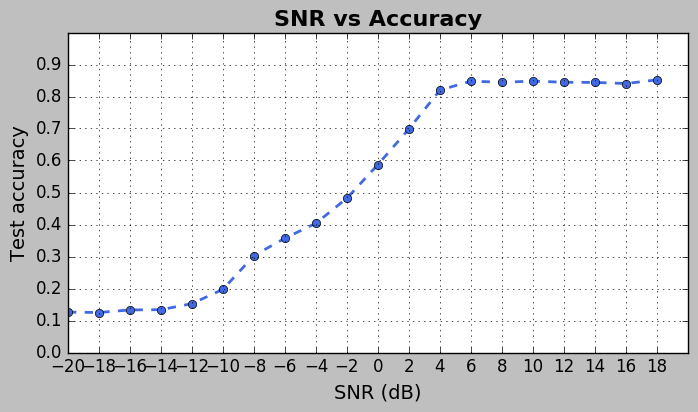

In [4]:
import matplotlib.pyplot as plt

plt.style.use('classic')

fig = plt.figure(figsize=(8, 4), dpi=100)
x = snrs
y = list(acc_test.values())
plt.plot(x, y, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('SNR vs Accuracy', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

In [ ]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import pandas as pd

classes = ['8PSK', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK']

with tf.Session() as sess:
    saver.restore(sess, path)
    Z = logits.eval(feed_dict = {X : X_32test_std[18]})
    predicted_18dB = np.argmax(Z, axis = 1)

conf_matrix = confusion_matrix(predicted_18dB, y_32_test[18]) 

#Normalize the matrix

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.round(decimals = 2)

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix")
print(df)

fig1 = plt.figure(figsize=(8, 4), dpi=100)
plt.imshow(conf_matrix, interpolation = 'nearest', cmap = plt.cm.Purples)
ticks = np.arange(len(classes))
plt.title("Confusion Matrix")
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.tight_layout()
plt.colorbar()
plt.show()